In [ ]:
!pip install nilearn==0.9.2
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
data_dir = '/content/drive/MyDrive/algonauts_2023_tutorial_data'
parent_submission_dir = '/content/drive/MyDrive/algonauts_2023_challenge_submission'

Mounted at /content/drive/


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device(device)
print(device)

cuda


In [ ]:
subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

In [ ]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):

    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

args = argObj(data_dir, parent_submission_dir, subj)

In [ ]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))

print('\nLH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')


LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)


In [ ]:
train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 9841
Test images: 159


In [ ]:
rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
from scipy.stats import pearsonr
import optuna

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the images to 224x224 pixels
    transforms.ToTensor(),  # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize the images color channels
])

# Define the custom dataset
class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img).to(device)
        return img


# Define the model and feature extractor
model = models.resnet50(pretrained=True)
model.to(device)
model.eval()
feature_extractor = nn.Sequential(*list(model.children())[:-1])



# Define the neural network for dimensionality reduction
class LinearizingEncodingModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1, hidden_dim2, activation1, activation2,
                 bnorm1, bnorm2, dropout1, dropout_ratio1, dropout2, dropout_ratio2):
        super(LinearizingEncodingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1) #initial
        if activation1:
            self.activation1 = activation1() #initial
        if bnorm1:
            self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        if dropout1:
            self.dropout1 = nn.Dropout(dropout_ratio1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2) #initially with output dim
        if activation2:
            self.activation2 = activation2()
        if bnorm2:
            self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        if dropout2:
            self.dropout2 = nn.Dropout(dropout_ratio2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x) #initial
        if hasattr(self, 'activation1'):
            x = self.activation1(x) #initial
        if hasattr(self, 'batchnorm1'):
            x = self.batchnorm1(x)
        if hasattr(self, 'dropout1'):
            x = self.dropout1(x)
        x = self.fc2(x) #initial
        if hasattr(self, 'activation2'):
            x = self.activation2(x)
        if hasattr(self, 'batchnorm2'):
            x = self.batchnorm2(x)
        if hasattr(self, 'dropout2'):
            x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Function to train the dimensionality reduction network
def train_linearizing_encoding_model(network, train_dataloader, train_targets, val_dataloader, val_targets, num_epochs, batch_size, loss_function, optimizer, learning_rate, save_name=None):
    criterion = loss_function
    optimizer = optimizer(network.parameters(), lr=learning_rate)
    network.train()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        training_loss = 0.0
        for index, data in enumerate(train_dataloader):



            inputs = data.to(device)
            inputs = feature_extractor(inputs)
            inputs = inputs.view(inputs.size(0), -1)


            #targets = torch.zeros(inputs.size(0), output_dim).to(device)  # Change target dimension to output_dim
            targets_batch = torch.tensor(train_targets[index*batch_size : index*batch_size + batch_size if index+batch_size <= train_targets.shape[0] else train_targets.shape[0]-index*batch_size]).to(device)
            #print(index*batch_size, index*batch_size + batch_size)

            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, targets_batch)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        training_loss /= len(train_dataloader)
        train_losses.append(training_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {training_loss:.4f}')

        network.eval()
        val_loss = 0.0
        with torch.no_grad():
            for index, data in enumerate(val_dataloader):
                inputs = data.to(device)
                inputs = feature_extractor(inputs)
                inputs = inputs.view(inputs.size(0), -1)

                targets_batch = torch.tensor(val_targets[index * batch_size: (index + 1) * batch_size]).to(device)

                outputs = network(inputs)
                loss = criterion(outputs, targets_batch)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    if save_name:
        torch.save(network.state_dict(), save_name+'.pt')

    return train_losses, val_losses





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [ ]:

# Get the output shape of the feature extractor layer
with torch.no_grad():
    sample_input = torch.zeros(1, 3, 224, 224).to(device)
    output = feature_extractor(sample_input)


print(f'Input dimension: {output.flatten().shape[0]}')

lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]

# Set the dimensions for input and output of the dimensionality reduction network
input_dim = output.shape[1]  # Use the output shape of the feature extractor
#input_dim = 512  # Dimension based on the ResNet18 architecture
output_dim = lh_fmri_train.shape[1]  # Desired output dimension
hidden_dim1 = 958 #256  # Number of hidden units in the network
hidden_dim2 = 458
num_epochs = 50
activation1 = nn.Tanh
activation2 = nn.Tanh
bnorm1 = True
bnorm2 = False
dropout1 = False
dropout_ratio1 = 0.0
dropout2 = True
dropout_ratio2 = 0.0
learning_rate = 0.0007265659377076724
optimizer = optim.Adam
loss_function = nn.MSELoss()
batch_size = 150

train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)

    # Train the dimensionality reduction network
network = LinearizingEncodingModel(input_dim, output_dim, hidden_dim1,  hidden_dim2, activation1, activation2, bnorm1, bnorm2, dropout1, dropout_ratio1, dropout2, dropout_ratio2).to(device)
train_losses, val_losses = train_linearizing_encoding_model(network, train_imgs_dataloader, lh_fmri_train, val_imgs_dataloader, lh_fmri_val, num_epochs, batch_size, loss_function, optimizer,  learning_rate, "resnet50_left_hemishpere")


Input dimension: 2048
Epoch 1/2, Training Loss: 0.4534
Validation - Epoch 1/2, Validation Loss: 0.4390
Epoch 2/2, Training Loss: 0.4262
Validation - Epoch 2/2, Validation Loss: 0.4336


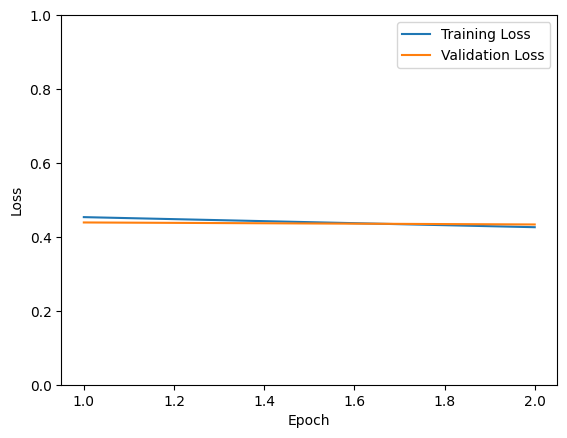

In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.savefig('resnet50_learning_curves_left_hemishpere.pdf', format='pdf')
plt.show()


In [ ]:
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)

with torch.no_grad():
    validation_features = []
    for data in val_imgs_dataloader:
        inputs = data.to(device)
        inputs = feature_extractor(inputs)
        inputs = inputs.view(inputs.size(0), -1)
        validation_features.append(inputs)
    validation_features = torch.cat(validation_features, dim=0)

lh_fmri_val = lh_fmri[idxs_val]
with torch.no_grad():
    network.eval()
    lh_fmri_val_pred = network(validation_features)

lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
for v in range(lh_fmri_val_pred.shape[1]):
    lh_correlation[v] = pearsonr(lh_fmri_val_pred[:, v].detach().cpu().numpy(), lh_fmri_val[:, v])[0]

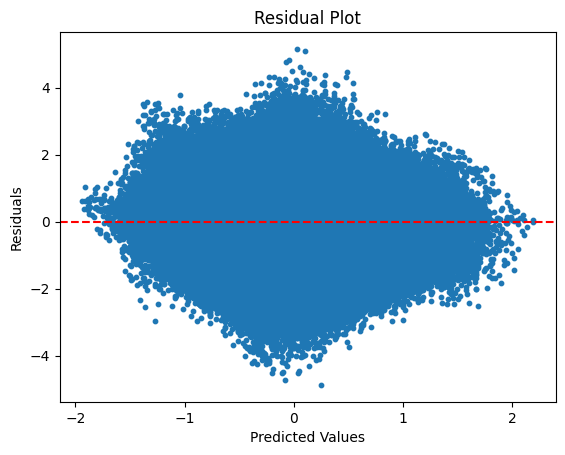

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate residuals
residuals = lh_fmri_val - lh_fmri_val_pred.cpu().detach().numpy()

# Plot the residual plot with thinner dots
plt.scatter(lh_fmri_val_pred.cpu().detach().numpy(), residuals, s=10)  # Adjust the size (s) parameter to make the dots thinner
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('resnet50_residual_plot_left_hemishpere.pdf', format='pdf')
plt.show()
